In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
def loadData(path):
    listOfTestFiles = os.listdir(path=path)
    train = []
    train_labels = []
    test = []
    test_labels = []
        
        
    print("Training files = ",listOfTestFiles[0:6])
    #For collecting Training data:
    for file in listOfTestFiles[0:6]:
        print(path+file)
        with open(path+file,'rb') as fo:
            dict = pickle.load(fo, encoding='latin1')
            train.append(dict['data'])
            train_labels.append(dict['labels'])

    print(listOfTestFiles[4])
    #for collecting Testing data
    with open(path+listOfTestFiles[4],'rb') as fo:
            dict = pickle.load(fo,encoding='latin1')
            test.append(dict['data'])
            test_labels.append(dict['labels'])

    dictData = {}
    dictData['train_data'] = np.reshape(np.array(train),newshape=(np.array(train).shape[0]*np.array(train).shape[1],np.array(train).shape[2]))
    dictData['train_labels'] = np.reshape(np.array(train_labels),newshape=(np.array(train_labels).shape[0]*np.array(train_labels).shape[1]))
    dictData['test_data'] = np.reshape(np.array(test),newshape=(np.array(test).shape[0]*np.array(test).shape[1],np.array(test).shape[2]))
    dictData['test_labels'] = np.reshape(np.array(test_labels),newshape=(np.array(test_labels).shape[0]*np.array(test_labels).shape[1]))
    return dictData

In [3]:
dataset = loadData(path='../cifar-10-batches-py/')

Training files =  ['data_batch_1', 'data_batch_2', 'data_batch_5', 'data_batch_4', 'data_batch_3']
./cifar-10-batches-py/data_batch_1
./cifar-10-batches-py/data_batch_2
./cifar-10-batches-py/data_batch_5
./cifar-10-batches-py/data_batch_4
./cifar-10-batches-py/data_batch_3
data_batch_3


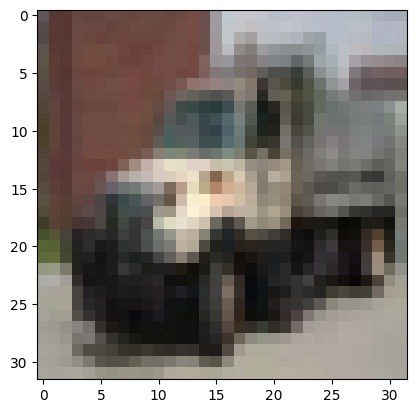

In [4]:
temp = dataset['test_data'][95]

R = temp[0:1024].reshape(32,32)
G = np.reshape(temp[1024:2048],newshape=(32,32))
B = np.reshape(temp[2048:],newshape=(32,32))
temp = np.dstack((R,G,B))   #for stacking all these 32,32 matrices.
plt.imshow(temp)
plt.show()

In [5]:
x_train,y_train, x_test, y_test = dataset['train_data'],dataset['train_labels'],dataset['test_data'],dataset['test_labels']

In [6]:
train_x,train_y = x_train[0:40000],y_train[0:40000]
val_x, val_y = x_train[40000:],y_train[40000:]

print("No. of training samples = ",train_x.shape[0])
print("No. of validation set samples = ",val_x.shape[0])

No. of training samples =  40000
No. of validation set samples =  10000


In [32]:
class KNN_Clasifier(object):
    def __init__(self, distance="L1"):
        self.distance = distance
        pass

    def train(self, x, y):
        self.Xtr = x
        self.Ytr = y

    def predict(self, x, k):
        num_test = x.shape[0]
        y_pred = np.zeros(num_test, dtype=self.Ytr.dtype)

        for i in range(num_test):
            label_count = np.zeros(10,dtype=self.Ytr.dtype)  
            if self.distance == "L1": 
                distances = np.sum(np.abs(self.Xtr - x[i, :]), axis=1)
            elif self.distance == "L2":
                distances = np.sqrt(np.sum(np.square(self.Xtr - x[i, :]), axis=1))
            else:
                throw("Distance must be either L1 or L2.")

            idx = np.argpartition(distances,k)

            min_ind = idx[:k]
            
            for j in min_ind:
                label_count[int(self.Ytr[j])] += 1
            y_pred[i] = np.argmax(label_count)

        return y_pred

--- 
Subsampling

In [28]:
num_training = 10000
mask = list(range(num_training))
X_train = train_x[mask]
y_train = train_y[mask]

num_test = 1000
mask = list(range(num_test))
X_test = train_x[mask]
y_test = train_y[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(10000, 3072) (1000, 3072)


In [29]:
knn = KNN_Clasifier()
knn.train(X_train, y_train)

In [30]:
yte_predict = knn.predict(X_test, 5)
print('Got with k:%d => accuracy: %f' % (5, np.mean(yte_predict==y_test)))

Got with k:5 => accuracy: 0.350000


In [33]:
knn = KNN_Clasifier(distance="L2")
knn.train(X_train, y_train)
yte_predict = knn.predict(X_test, 5)
print('Got with k:%d => accuracy: %f' % (5, np.mean(yte_predict==y_test)))

Got with k:5 => accuracy: 0.373000


In [34]:
num_folds = 5
k_choices = [1, 10, 20]

X_train_folds = []
y_train_folds = []

In [35]:
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}

In [36]:
for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0, num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds

        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)

        classifier = KNN_Clasifier()
        classifier.train(X_train, y_train)
        y_test_pred = classifier.predict(X_test, k)

        yte_predict = knn.predict(X_test, 5)
        accuracy = np.mean(yte_predict==y_test)
        print(f"For k: {k} On fold [{num_knn + 1}/{num_folds}] - Accuracy: {accuracy}")
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

For k: 1 On fold [1/5] - Accuracy: 0.3705
For k: 1 On fold [2/5] - Accuracy: 0.3785
For k: 1 On fold [3/5] - Accuracy: 0.3885
For k: 1 On fold [4/5] - Accuracy: 0.3715
For k: 1 On fold [5/5] - Accuracy: 0.39
For k: 10 On fold [1/5] - Accuracy: 0.3705
For k: 10 On fold [2/5] - Accuracy: 0.3785
For k: 10 On fold [3/5] - Accuracy: 0.3885
For k: 10 On fold [4/5] - Accuracy: 0.3715
For k: 10 On fold [5/5] - Accuracy: 0.39
For k: 20 On fold [1/5] - Accuracy: 0.3705
For k: 20 On fold [2/5] - Accuracy: 0.3785
For k: 20 On fold [3/5] - Accuracy: 0.3885
For k: 20 On fold [4/5] - Accuracy: 0.3715
For k: 20 On fold [5/5] - Accuracy: 0.39
Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.370500
k = 1, accuracy = 0.378500
k = 1, accuracy = 0.388500
k = 1, accuracy = 0.371500
k = 1, accuracy = 0.390000
k = 10, accuracy = 0.370500
k = 10, accuracy = 0.378500
k = 10, accuracy = 0.388500
k = 10, accuracy = 0.371500
k = 10, accuracy = 0.390000
k = 20, accuracy = 0.370500
k = 20